In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

!pip install -q mahotas
import mahotas
import pandas as pd
import seaborn as sns

Mounted at /content/drive
Clases encontradas: ['Citrus Limon (Lemon)', 'Mangifera Indica (Mango)']


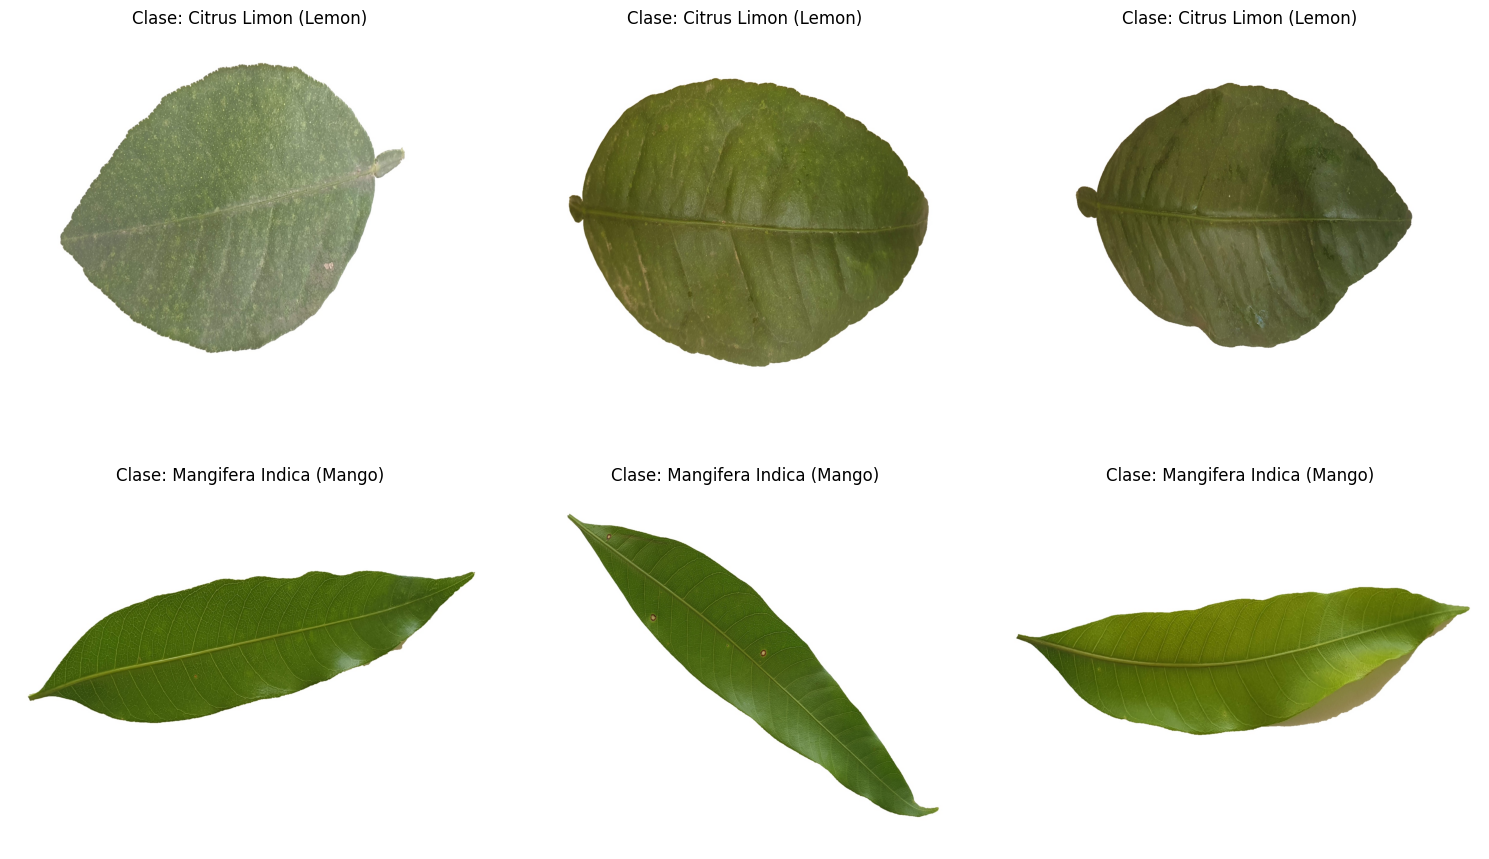

In [ ]:

# Montar Google Drive
drive.mount('/content/drive')

# Ruta de la carpeta de datos
input_path = "/content/drive/MyDrive/VISIÓN POR COMPUTADORA/DATOS"

# Obtener la lista de clases (subcarpetas)
classes = sorted(os.listdir(input_path))
print("Clases encontradas:", classes)

# Configurar matplotlib para mostrar imágenes
plt.figure(figsize=(15, 10))

# Recorrer cada clase y mostrar 3 imágenes
for i, class_name in enumerate(classes):
    class_path = os.path.join(input_path, class_name)
    images = os.listdir(class_path)[:3]  # Tomar las primeras 3 imágenes

    for j, image_name in enumerate(images):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB para matplotlib

        # Mostrar la imagen
        plt.subplot(len(classes), 3, i * 3 + j + 1)
        plt.imshow(image)
        plt.title(f"Clase: {class_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()


🔍 Procesando clase: Mangifera Indica (Mango)
✅ Segmentación completa para clase: Mangifera Indica (Mango)

🔍 Procesando clase: Citrus Limon (Lemon)
✅ Segmentación completa para clase: Citrus Limon (Lemon)


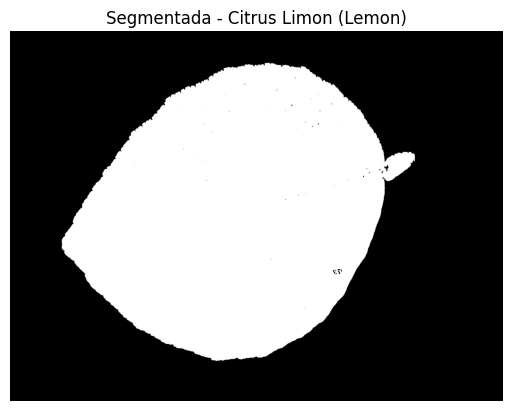

In [ ]:

# Rutas de entrada y salida
input_folder_path = '/content/drive/MyDrive/VISIÓN POR COMPUTADORA/DATOS'
output_base_path = '/content/drive/MyDrive/VISIÓN POR COMPUTADORA/SEGMENTADAS'

# Función para segmentar la imagen con Otsu
def segment_image(image_path):
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"❌ No se pudo leer la imagen: {image_path}")
            return None

        blurred = cv2.GaussianBlur(image, (5, 5), 0)
        T = mahotas.thresholding.otsu(blurred)
        segmented = (blurred > T).astype(np.uint8) * 255
        segmented = cv2.bitwise_not(segmented)
        return segmented
    except Exception as e:
        print(f"⚠️ Error al procesar {image_path}: {e}")
        return None

# Procesamiento por clase (limón, mango)
if os.path.exists(input_folder_path):
    for class_name in os.listdir(input_folder_path):
        class_path = os.path.join(input_folder_path, class_name)

        if os.path.isdir(class_path):
            output_class_path = os.path.join(output_base_path, f"{class_name}_segmentadas")
            os.makedirs(output_class_path, exist_ok=True)
            print(f"\n🔍 Procesando clase: {class_name}")

            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

            for image_name in image_files:
                image_path = os.path.join(class_path, image_name)
                segmented = segment_image(image_path)

                if segmented is not None:
                    output_path = os.path.join(output_class_path, image_name)
                    cv2.imwrite(output_path, segmented)

            print(f"✅ Segmentación completa para clase: {class_name}")
else:
    print(f"❌ Carpeta no encontrada: {input_folder_path}")


from matplotlib import pyplot as plt

sample_image = os.path.join(output_class_path, image_files[0])
seg = cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)

plt.imshow(seg, cmap='gray')
plt.title(f"Segmentada - {class_name}")
plt.axis('off')
plt.show()

In [ ]:
# Ruta donde están las carpetas con imágenes segmentadas
segmented_root = '/content/drive/MyDrive/VISIÓN POR COMPUTADORA/SEGMENTADAS'

# Lista para guardar los datos
data = []

# Iterar sobre las clases (limón, mango)
for class_folder in os.listdir(segmented_root):
    class_path = os.path.join(segmented_root, class_folder)

    if not os.path.isdir(class_path):
        continue

    for image_file in os.listdir(class_path):
        if not image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            continue

        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"⚠️ No se pudo leer: {image_path}")
            continue

        # Encontrar contornos (hoja blanca sobre fondo negro)
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            print(f"⚠️ No se encontraron contornos en: {image_path}")
            continue

        # Elegir el contorno más grande (por si hay ruido)
        largest_contour = max(contours, key=cv2.contourArea)

        # Calcular área y perímetro
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)

        # Redondez
        roundness = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

        # Ajuste de elipse (solo si hay al menos 5 puntos)
        eje_menor = eje_mayor = excentricidad = np.nan
        if len(largest_contour) >= 5:
            ellipse = cv2.fitEllipse(largest_contour)
            (x, y), (major_axis, minor_axis), angle = ellipse

            eje_mayor = max(major_axis, minor_axis)
            eje_menor = min(major_axis, minor_axis)

            # Excentricidad  (La raíz es para evitar valores negativos y se le resta 1 para mirar la diferencia con un círculo perfecto)
            excentricidad = np.sqrt(1 - (eje_menor / eje_mayor) ** 2) if eje_mayor != 0 else 0

        # Guardar los resultados
        data.append({
            'Clase': class_folder.replace('_segmentadas', ''),
            'Nombre_imagen': image_file,
            'Área': area,
            'Perímetro': perimeter,
            'Redondez': roundness,
            'Eje mayor': eje_mayor,
            'Eje menor': eje_menor,
            'Excentricidad': excentricidad
        })

# Crear DataFrame
df = pd.DataFrame(data)

# Guardar a CSV
output_csv = '/content/drive/MyDrive/VISIÓN POR COMPUTADORA/Características geométricas.csv'
df.to_csv(output_csv, index=False)

print(f"✅ Archivo CSV guardado en: {output_csv}")
print (df)


✅ Archivo CSV guardado en: /content/drive/MyDrive/VISIÓN POR COMPUTADORA/Características geométricas.csv
                        Clase Nombre_imagen      Área     Perímetro  Redondez  \
0    Mangifera Indica (Mango)  MI-S-017.jpg  444459.5   8375.807459  0.079614   
1    Mangifera Indica (Mango)  MI-S-008.jpg  355485.5   9206.477715  0.052704   
2    Mangifera Indica (Mango)  MI-S-035.jpg  466705.5   8058.004294  0.090323   
3    Mangifera Indica (Mango)  MI-S-018.jpg  297186.0   9053.382263  0.045563   
4    Mangifera Indica (Mango)  MI-S-039.jpg  401314.5   8125.332284  0.076386   
..                        ...           ...       ...           ...       ...   
114      Citrus Limon (Lemon)  CL-S-034.jpg  882171.0  10612.018032  0.098439   
115      Citrus Limon (Lemon)  CL-S-047.jpg  661944.5   8159.724200  0.124934   
116      Citrus Limon (Lemon)  CL-S-026.jpg  914614.0  10422.939824  0.105796   
117      Citrus Limon (Lemon)  CL-S-035.jpg  395946.0   6960.433668  0.102701   
118 

In [ ]:


# Ruta de las imágenes segmentadas
segmented_root = '/content/drive/MyDrive/VISIÓN POR COMPUTADORA/SEGMENTADAS'

# Lista para almacenar los momentos de Hu
hu_data = []

# Iterar sobre cada clase (limón, mango)
for class_folder in os.listdir(segmented_root):
    class_path = os.path.join(segmented_root, class_folder)

    if not os.path.isdir(class_path):
        continue

    # Procesar cada imagen
    for image_file in os.listdir(class_path):
        if not image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            continue

        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"⚠️ No se pudo leer: {image_path}")
            continue

        # Encontrar contornos
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            print(f"⚠️ No hay contornos en: {image_path}")
            continue

        # Tomar el contorno más grande
        largest_contour = max(contours, key=cv2.contourArea)

        # Calcular momentos de Hu
        moments = cv2.moments(largest_contour)
        hu_moments = cv2.HuMoments(moments)

        # Aplanar los momentos de Hu (son 7 valores)
        hu_moments_flat = [hu_moments[i][0] for i in range(7)]

        # Guardar en la lista
        hu_data.append({
            'Clase': class_folder.replace('_segmentadas', ''),
            'Imagen': image_file,
            'Hu1': hu_moments_flat[0],
            'Hu2': hu_moments_flat[1],
            'Hu3': hu_moments_flat[2],
            'Hu4': hu_moments_flat[3],
            'Hu5': hu_moments_flat[4],
            'Hu6': hu_moments_flat[5],
            'Hu7': hu_moments_flat[6]
        })

# Crear DataFrame con los momentos de Hu
df_hu = pd.DataFrame(hu_data)

# Guardar en un CSV independiente
hu_csv_path = '/content/drive/MyDrive/VISIÓN POR COMPUTADORA/Momentos_de_Hu.csv'
df_hu.to_csv(hu_csv_path, index=False)

print(f"✅ Momentos de Hu guardados en: {hu_csv_path}")
print(df_hu.head())  # Mostrar las primeras filas

✅ Momentos de Hu guardados en: /content/drive/MyDrive/VISIÓN POR COMPUTADORA/Momentos_de_Hu.csv
                      Clase        Imagen       Hu1       Hu2       Hu3  \
0  Mangifera Indica (Mango)  MI-S-017.jpg  0.287726  0.056676  0.000522   
1  Mangifera Indica (Mango)  MI-S-008.jpg  0.371492  0.111510  0.001392   
2  Mangifera Indica (Mango)  MI-S-035.jpg  0.274923  0.047986  0.001188   
3  Mangifera Indica (Mango)  MI-S-018.jpg  0.387094  0.122840  0.001080   
4  Mangifera Indica (Mango)  MI-S-039.jpg  0.319133  0.073468  0.002386   

        Hu4           Hu5       Hu6           Hu7  
0  0.000277  1.051509e-07  0.000066  3.749673e-09  
1  0.000858  9.356523e-07  0.000276 -4.792123e-08  
2  0.000103 -3.423999e-08 -0.000022 -1.057699e-08  
3  0.000429  2.796767e-07  0.000108 -8.447863e-08  
4  0.000647  7.061499e-07  0.000111  3.847308e-07  


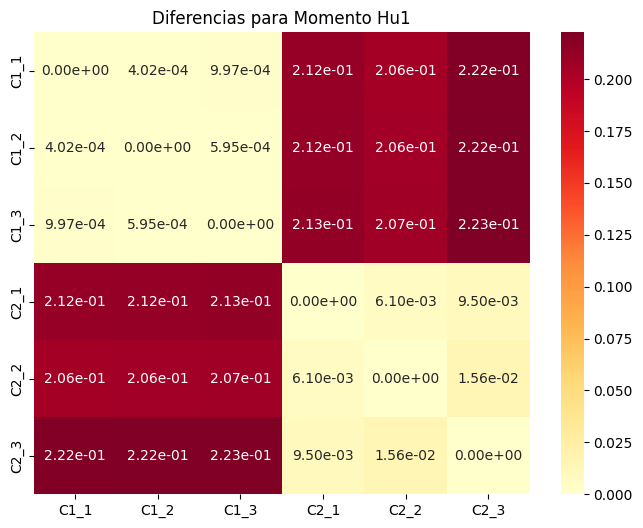

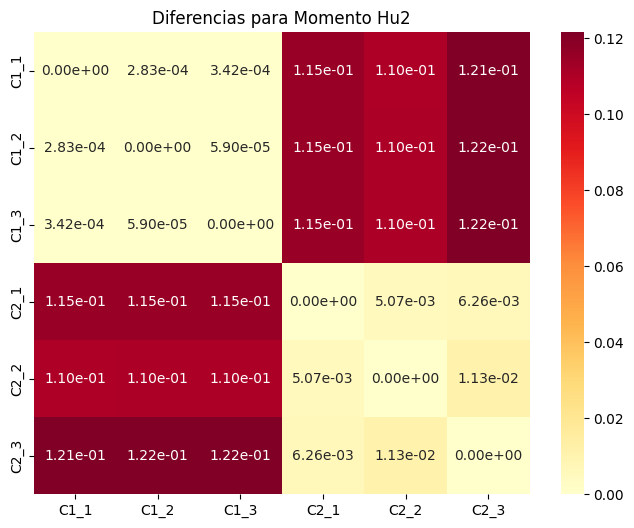

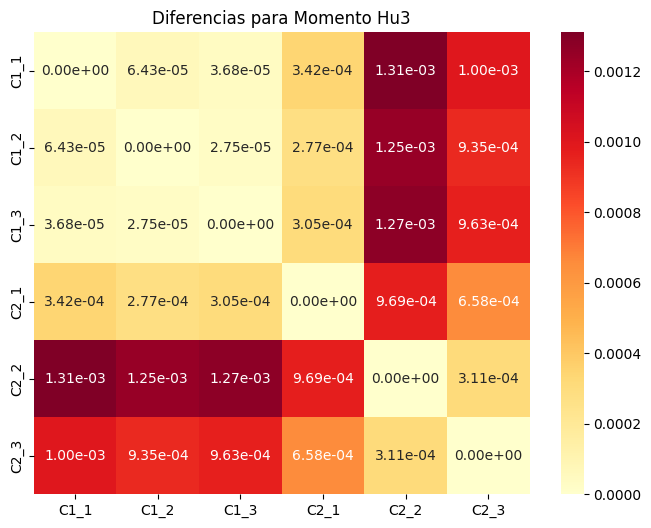

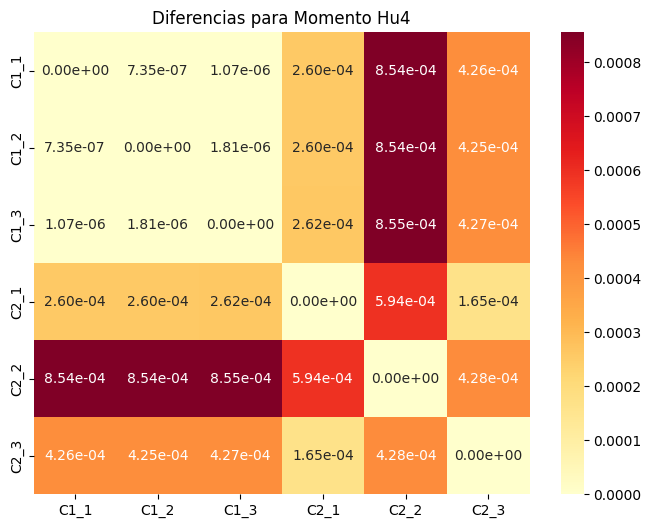

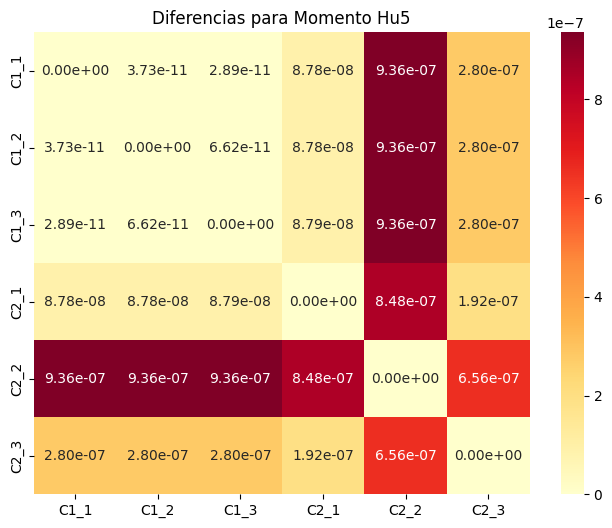

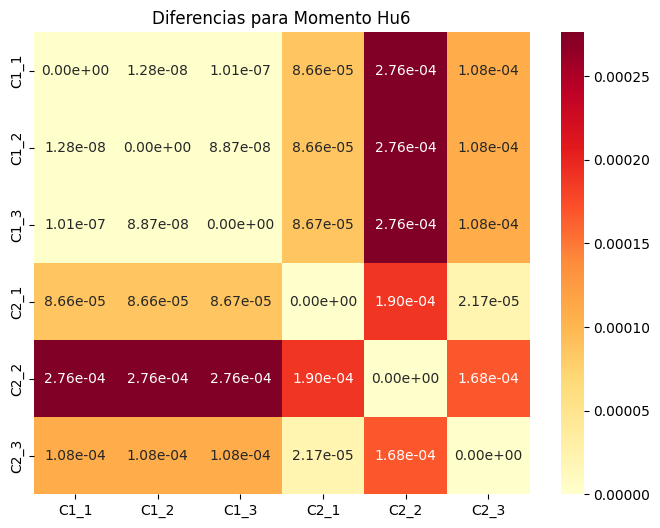

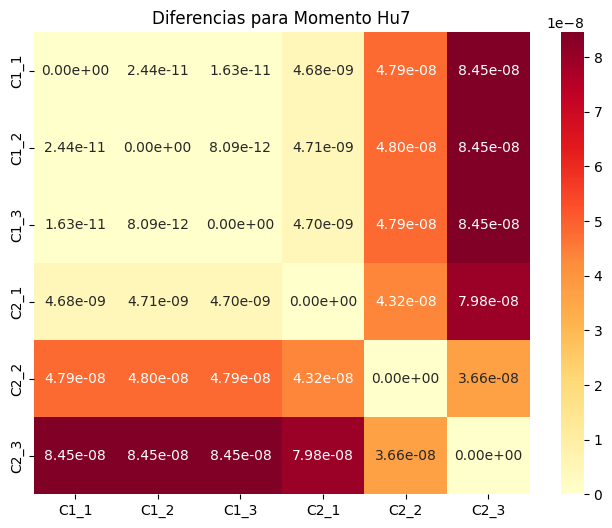

In [ ]:

# Cargar los datos de momentos de Hu
hu_csv_path = '/content/drive/MyDrive/VISIÓN POR COMPUTADORA/Momentos_de_Hu.csv'
df_hu = pd.read_csv(hu_csv_path)

# Configuración manual de las imágenes a analizar
#Se seleccionaron las imágenes con mayor y menor redondez
imagenes_seleccionadas = [
    'CL-S-019.jpg',  # Clase 1, imagen 1
    'CL-S-015.jpg',  # Clase 1, imagen 2
    'CL-S-013.jpg',  # Clase 1, imagen 3
    'MI-S-001.jpg',  # Clase 2, imagen 1
    'MI-S-008.jpg',  # Clase 2, imagen 2
    'MI-S-018.jpg'   # Clase 2, imagen 3
]

# Filtrar el DataFrame con las imágenes seleccionadas
df_selected = df_hu[df_hu['Imagen'].isin(imagenes_seleccionadas)].copy()

# Verificar que tenemos exactamente 6 imágenes
if len(df_selected) != 6:
    raise ValueError(f"Se esperaban 6 imágenes pero se encontraron {len(df_selected)}. Verifica los nombres.")

# Ordenar las imágenes según el orden especificado en imagenes_seleccionadas
df_selected = df_selected.set_index('Imagen').loc[imagenes_seleccionadas].reset_index()

# Crear nombres simplificados para las matrices
nombres_simplificados = [f"C1_{i+1}" if 'CL' in img else f"C2_{i-2}"
                         for i, img in enumerate(imagenes_seleccionadas)]
df_selected['Nombre_simplificado'] = nombres_simplificados

# Función para crear matriz de diferencias para un momento específico
def crear_matriz_calor(momento_num, df):
    # Extraer los valores del momento especificado
    columna = f'Hu{momento_num}'
    valores = df[columna].values

    # Calcular matriz de diferencias absolutas
    matriz_diferencias = np.abs(valores[:, None] - valores[None, :])

    # Crear heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_diferencias, annot=True, fmt=".2e",
                xticklabels=df['Nombre_simplificado'],
                yticklabels=df['Nombre_simplificado'],
                cmap="YlOrRd")
    plt.title(f'Diferencias para Momento Hu{momento_num}')
    plt.show()

# Crear matrices para los 7 momentos de Hu
for momento in range(1, 8):
    crear_matriz_calor(momento, df_selected)